### Import Libraries and connect to drive

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
# importing required libraries
import numpy as np
import pandas as pd

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC
# importing library for K-neares-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
# importing library for Linear Discriminant Analysis Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# importing library for Quadratic Discriminant Analysis Model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# representation of model layers
from keras.utils.vis_utils import plot_model
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### CNN_Model_Development

In [ ]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/MajorProjectKDD/multi/train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/MajorProjectKDD/multi/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 2961 images belonging to 4 classes.
Found 740 images belonging to 4 classes.


### Define the image plotting functions

In [ ]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [ ]:
history_this= LossHistory()

### Construct CNN models

#### Model 1: a CNN model by own (baseline)

In [ ]:
model = Sequential()
def cnn_by_own(input_shape,num_class,epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/model_own.h5'):
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.0197 - accuracy: 0.4887 
Epoch 1: accuracy improved from -inf to 0.48869, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/model_own.h5
24/24 [==============================] - 1511s 61s/step - loss: 1.0197 - accuracy: 0.4887 - val_loss: 0.8844 - val_accuracy: 0.5297
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.8110 - accuracy: 0.5214
Epoch 2: accuracy improved from 0.48869 to 0.52145, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/model_own.h5
24/24 [==============================] - 33s 1s/step - loss: 0.8110 - accuracy: 0.5214 - val_loss: 0.5488 - val_accuracy: 0.6730
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8875
Epoch 3: accuracy improved from 0.52145 to 0.88754, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/model_own.h5
24/24 [==============================] - 34s 1s/step - loss: 0.3522 - accuracy: 0

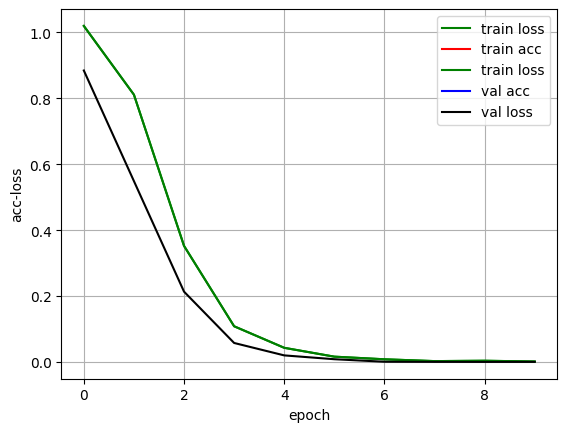

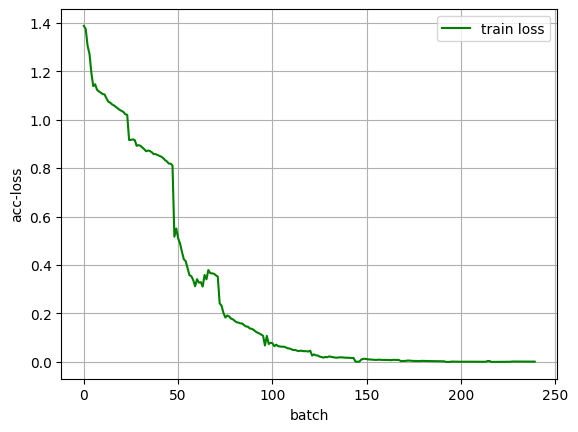

In [ ]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=4,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### For a given image Testing the model

In [ ]:
img_test = image.load_img("/content/drive/MyDrive/MajorProjectKDD/multi/test_224/1/14816.png", target_size=(224, 224))
img_array = image.img_to_array(img_test)
# expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# normalize the image
img_array /= 255.

# make the prediction
prediction = model.predict(img_array)

# print the predicted class label
print(np.argmax(prediction))

In [ ]:
img_test = image.load_img("/content/drive/MyDrive/MajorProjectKDD/multi/test_224/0/19039.png", target_size=(224, 224))
img_array = image.img_to_array(img_test)
# expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# normalize the image
img_array /= 255.

# make the prediction
prediction = model.predict(img_array)

# print the predicted class label
print(np.argmax(prediction))

1/1 [==============================] - 1s 642ms/step
0


### Xception

In [10]:
def xception( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8740
Epoch 1: val_accuracy improved from -inf to 0.98514, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/xception.h5
24/24 [==============================] - 31s 1s/step - loss: 0.3586 - accuracy: 0.8740 - val_loss: 0.0726 - val_accuracy: 0.9851
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9885
Epoch 2: val_accuracy improved from 0.98514 to 0.99459, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/xception.h5
24/24 [==============================] - 22s 904ms/step - loss: 0.0494 - accuracy: 0.9885 - val_loss: 0.0195 - val_accuracy: 0.9946
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9959
Epoch 3: val_accuracy improved from 0.99459 to 0.99730, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/xception.h5
24/24 [==============================] - 22s 897ms/step - loss: 0.0199 - 

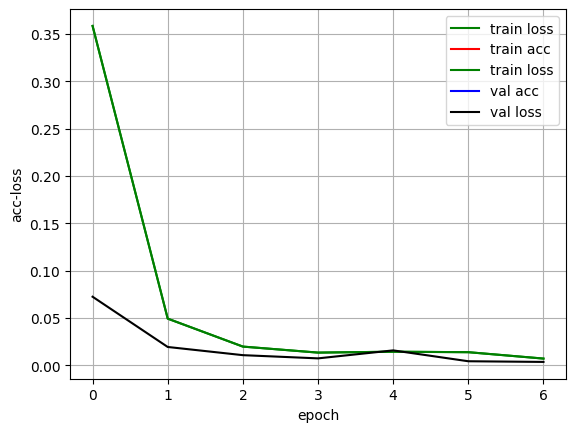

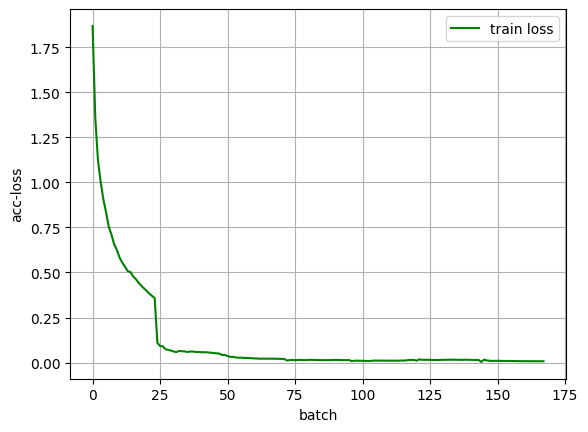

In [11]:
#default only 50, tf36cnn 99
xception(num_class=4,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 3: VGG16

In [12]:

def vgg16( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.1412 - accuracy: 0.6008
Epoch 1: val_accuracy improved from -inf to 0.89189, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG16.h5
24/24 [==============================] - 53s 1s/step - loss: 1.1412 - accuracy: 0.6008 - val_loss: 0.4018 - val_accuracy: 0.8919
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9139
Epoch 2: val_accuracy improved from 0.89189 to 0.99054, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG16.h5
24/24 [==============================] - 20s 839ms/step - loss: 0.2766 - accuracy: 0.9139 - val_loss: 0.0728 - val_accuracy: 0.9905
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9899
Epoch 3: val_accuracy improved from 0.99054 to 0.99324, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG16.h5
24/24 [==========

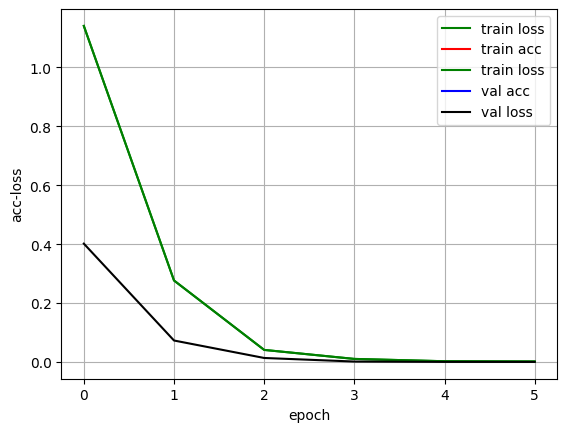

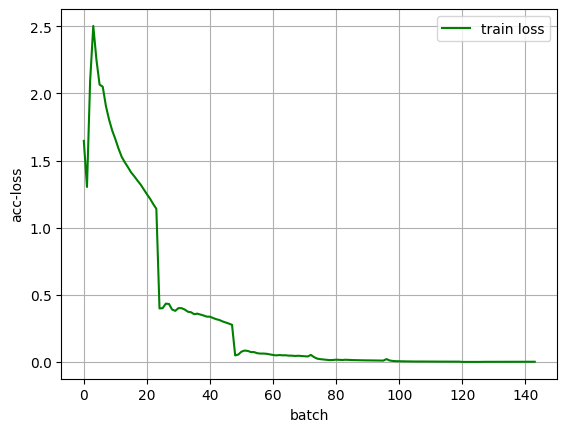

In [13]:
vgg16(num_class=4,epochs=10)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 4: VGG19

In [14]:
def vgg19( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.8534
Epoch 1: val_accuracy improved from -inf to 0.98919, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG19.h5
24/24 [==============================] - 26s 1s/step - loss: 0.4979 - accuracy: 0.8534 - val_loss: 0.0512 - val_accuracy: 0.9892
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9895
Epoch 2: val_accuracy improved from 0.98919 to 0.99730, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG19.h5
24/24 [==============================] - 24s 969ms/step - loss: 0.0415 - accuracy: 0.9895 - val_loss: 0.0082 - val_accuracy: 0.9973
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9986
Epoch 3: val_accuracy improved from 0.99730 to 1.00000, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/VGG19.h5
24/24 [==========

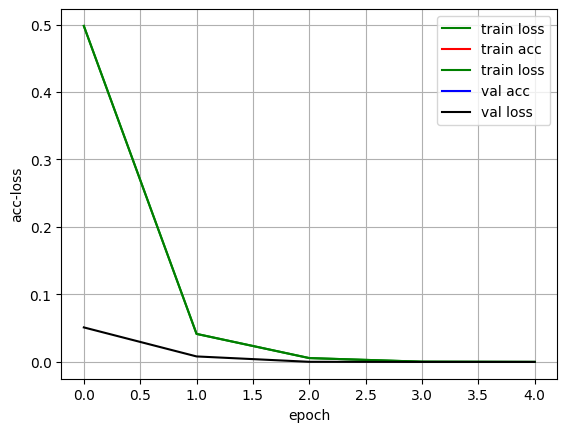

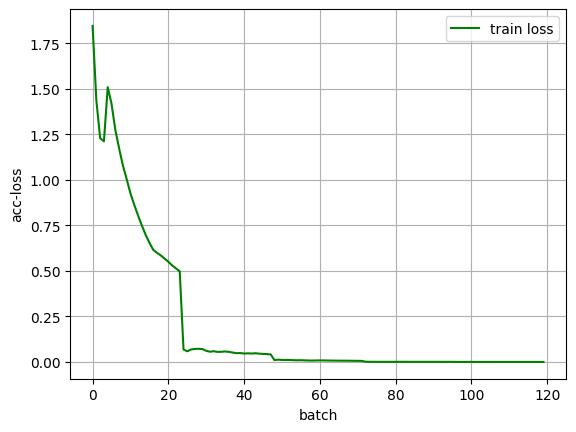

In [15]:
vgg19(num_class=4,epochs=10)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 5: ResNet

In [16]:
def resnet( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8872
Epoch 1: val_accuracy improved from -inf to 0.36216, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/resnet.h5
24/24 [==============================] - 39s 1s/step - loss: 0.3393 - accuracy: 0.8872 - val_loss: 2205.2131 - val_accuracy: 0.3622
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9926
Epoch 2: val_accuracy did not improve from 0.36216
24/24 [==============================] - 22s 901ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 1207.8394 - val_accuracy: 0.3622
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9976
Epoch 3: val_accuracy did not improve from 0.36216
24/24 [==============================] - 19s 777ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 198.9399 - val_accuracy: 0.3622
Epoch 3: early stopping


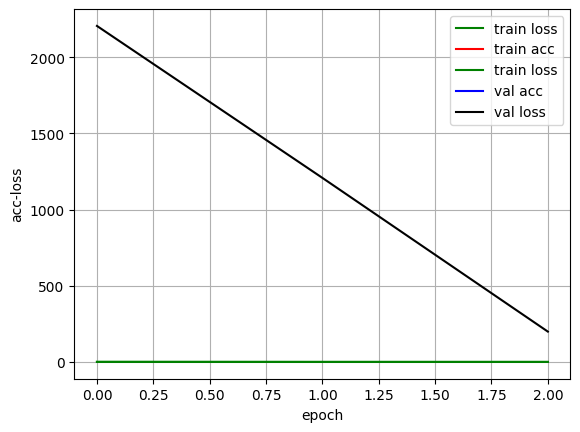

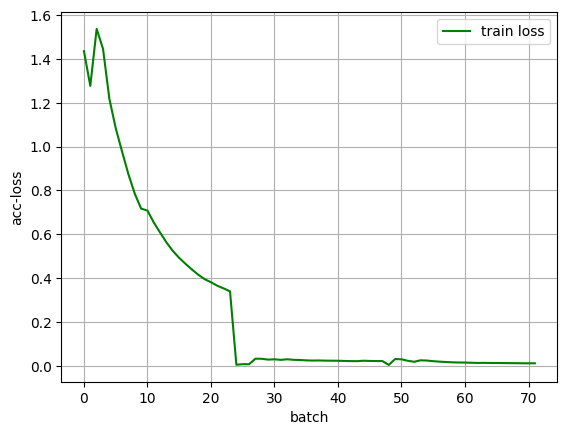

In [17]:
resnet(num_class=4,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 6: Inception

In [18]:
def inception( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/10
 6/24 [======>.......................] - ETA: 12s - loss: 0.5238 - accuracy: 0.7930

24/24 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9426
Epoch 1: val_accuracy improved from -inf to 0.86081, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/inception.h5
24/24 [==============================] - 47s 1s/step - loss: 0.1517 - accuracy: 0.9426 - val_loss: 2.5322 - val_accuracy: 0.8608
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9990
Epoch 2: val_accuracy did not improve from 0.86081
24/24 [==============================] - 21s 840ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 12.7920 - val_accuracy: 0.5378
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 7.3029e-04 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.86081 to 0.89189, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/inception.h5
24/24 [==============================] - 24s 988ms/step - loss: 7.3029e-04 - accuracy: 1.0000 - val_loss: 15.4790 - val_accuracy: 0.8919
Epoch 4/10
24/24 [

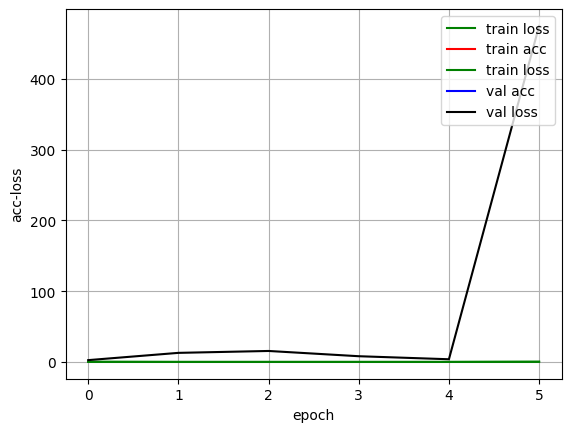

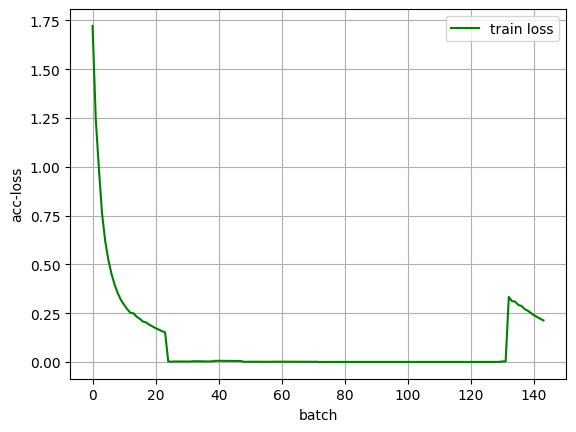

In [19]:
inception(num_class=4,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

### Model 7: InceptionResnet

In [20]:
def inceptionresnet( num_class, epochs,savepath='/content/drive/MyDrive/MajorProjectKDD/multi/inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

219055592/219055592 [==============================] - 7s 0us/step
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9436
Epoch 1: val_accuracy improved from -inf to 0.01216, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/inceptionresnet.h5
24/24 [==============================] - 63s 2s/step - loss: 0.1378 - accuracy: 0.9436 - val_loss: 165.1872 - val_accuracy: 0.0122
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9980
Epoch 2: val_accuracy improved from 0.01216 to 0.88919, saving model to /content/drive/MyDrive/MajorProjectKDD/multi/inceptionresnet.h5
24/24 [==============================] - 38s 2s/step - loss: 0.0372 - accuracy: 0.9980 - val_loss: 54.0052 - val_accuracy: 0.8892
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9976
Epoch 3: val_accuracy did not improve from 0.88919
24/24 [==============================] - 31s 1s/step - loss: 0.0090 - 

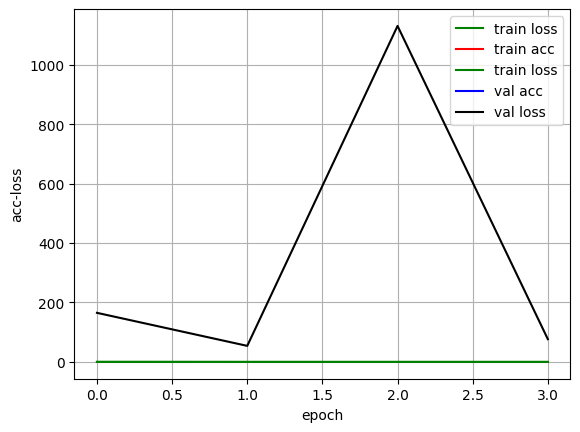

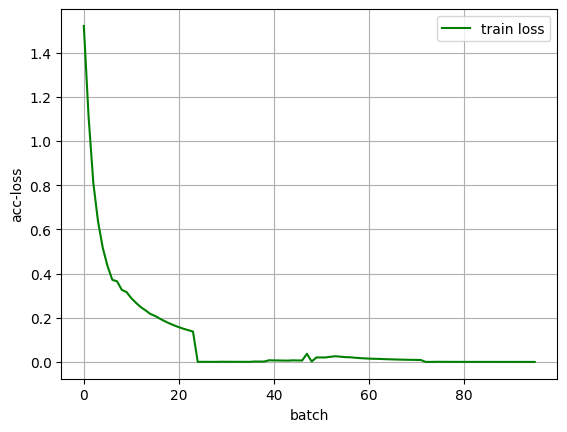

In [21]:
inceptionresnet(num_class=4,epochs=10)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()